In [1]:
import os, sys
import glob
import pickle
import numpy as np
import pandas as pd 
# !pip install cclib
import cclib

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
import rdkit.Chem as chem
import rdkit.Chem.AllChem as allchem

from mordred import Calculator, descriptors

In [2]:
# helper functions
def mfs(s):
    return chem.MolFromSmiles(s)

def mts(m):
    return chem.MolToCXSmiles(m)

In [3]:
# load the fragments
# df_a = pd.read_csv('a_frags.csv')
# df_b = pd.read_csv('b_frags.csv')
df_a = pd.read_csv('TIDA_a_frags.csv')
df_b = pd.read_csv('TIDA_b_frags.csv')
df_c = pd.read_csv('c_frags.csv')
print(df_a.shape, df_b.shape, df_c.shape)
df_a.head()

(32, 11) (38, 10) (161, 10)


,Unnamed: 0,molecule_id,created_on,updated_on,hid,smiles,commercially_available,CAS,molecule_type_id,xdl,smiles_w_sub
0,0,6bf2b5a1-c157-4b5a-8a80-bf0b44704273,2022-01-18T12:59:55.557052,2022-01-18T12:59:55.557052,A001,CC1(C)OB(c2ccc(-n3c4ccccc4c4ccccc43)cc2)OC1(C)C,True,785051-54-9,2d012b56-8260-4f9e-8ede-2c8546baf21c,NaN,FC(F)=Cc1ccc(-n2c3ccccc3c3ccccc32)cc1
1,1,b2272f91-8f3d-41a5-87d4-8c473af1da0e,2022-01-18T13:00:03.958016,2022-01-18T13:00:03.958016,A002,CC1(C)OB(c2ccc(N(c3ccccc3)c3ccccc3)cc2)OC1(C)C,True,267221-88-5,2d012b56-8260-4f9e-8ede-2c8546baf21c,NaN,FC(F)=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1
2,2,64ee9f15-7a47-4297-9e10-abc3c434c4e9,2022-01-18T13:00:12.229953,2022-01-18T13:00:12.229953,A003,COc1ccc(N(c2ccc(OC)cc2)c2ccc(B3OC(C)(C)C(C)(C)...,True,875667-84-8,2d012b56-8260-4f9e-8ede-2c8546baf21c,NaN,COc1ccc(N(c2ccc(C=C(F)F)cc2)c2ccc(OC)cc2)cc1
3,3,c669230e-aeb4-47db-8948-cadbdea4f198,2022-01-18T13:00:20.943680,2022-01-18T13:00:20.943680,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(B2OC(C)(C)C(C)(...,True,1218791-29-7,2d012b56-8260-4f9e-8ede-2c8546baf21c,NaN,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(C=C(F)F)cc1
4,7,c6b85389-1f54-4323-9abd-1c1685b29d94,2022-01-18T13:01:09.176952,2022-01-18T13:01:09.176952,A008,CC1(C)OB(c2ccc3c(c2)c2ccccc2n3-c2ccccc2)OC1(C)C,True,1126522-69-7,2d012b56-8260-4f9e-8ede-2c8546baf21c,NaN,FC(F)=Cc1ccc2c(c1)c1ccccc1n2-c1ccccc1


In [4]:
a_hid = df_a['hid'].tolist()
b_hid = df_b['hid'].tolist()
c_hid = df_c['hid'].tolist()
a_smiles = df_a['smiles_w_sub'].tolist()
b_smiles = df_b['smiles_w_sub'].tolist()
c_smiles = df_c['smiles_w_sub'].tolist()
a_mols = [mfs(s) for s in a_smiles]
b_mols = [mfs(s) for s in b_smiles]
c_mols = [mfs(s) for s in c_smiles]
type_a = ['a' for _ in range(len(a_smiles))]
type_b = ['b' for _ in range(len(b_smiles))]
type_c = ['c' for _ in range(len(c_smiles))]

In [5]:
df = pd.DataFrame({
    'type': type_a+type_b+type_c,
    'hid': a_hid+b_hid+c_hid,
    'smiles': a_smiles+b_smiles+c_smiles,
    'mol': a_mols+b_mols+c_mols,
})
print(df.shape)
print(df.columns)
df.head()

(231, 4)
Index(['type', 'hid', 'smiles', 'mol'], dtype='object')


,type,hid,smiles,mol
0,a,A001,FC(F)=Cc1ccc(-n2c3ccccc3c3ccccc32)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a0db460>
1,a,A002,FC(F)=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a0db700>
2,a,A003,COc1ccc(N(c2ccc(C=C(F)F)cc2)c2ccc(OC)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a1340a0>
3,a,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(C=C(F)F)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a134100>
4,a,A008,FC(F)=Cc1ccc2c(c1)c1ccccc1n2-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a134160>


In [6]:
# compute mordred descriptors
calc = Calculator(descriptors, ignore_3D=True)
print('num desc :', len(calc.descriptors))

df_mord_tmp = calc.pandas(df['mol'].tolist())

num desc : 1613


100%|██████████| 231/231 [00:13<00:00, 16.72it/s]


In [7]:
df_mord_tmp

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,18.360915,14.108647,0,0,30.639353,2.553000,4.912845,30.639353,1.332146,4.092384,...,10.187651,72.392461,305.101606,8.475045,1165,38,126.0,152.0,6.138889,5.000000
1,17.775129,14.078058,0,0,30.199705,2.405815,4.811629,30.199705,1.313031,4.057079,...,9.895002,56.999138,307.117256,8.082033,1210,33,116.0,133.0,6.416667,5.166667
2,20.603556,15.897906,0,0,35.081009,2.421349,4.842699,35.081009,1.299297,4.210198,...,10.079078,61.842273,367.138385,7.981269,1922,41,136.0,157.0,8.638889,6.166667
3,18.361274,15.392245,0,0,28.895359,2.398488,4.796976,28.895359,1.203973,4.080950,...,9.931638,58.175362,331.138385,7.700893,1369,33,120.0,134.0,9.479167,5.208333
4,18.360915,14.260568,0,0,30.632069,2.561265,4.917294,30.632069,1.331829,4.092388,...,10.193280,72.399733,305.101606,8.475045,1117,38,126.0,152.0,6.138889,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,9.928005,9.935624,0,0,17.226138,2.377309,4.577292,17.226138,1.230438,3.524155,...,9.209240,58.817681,192.078644,7.387640,309,18,64.0,73.0,5.944444,3.472222
227,9.220898,9.388907,0,0,16.248218,2.374764,4.565720,16.248218,1.249863,3.454590,...,9.174402,57.563267,178.062994,7.741869,245,17,60.0,69.0,5.694444,3.222222
228,9.928005,9.610505,0,0,17.726562,2.342923,4.685846,17.726562,1.266183,3.521554,...,9.304650,45.053394,189.078979,7.563159,299,20,64.0,73.0,5.944444,3.472222
229,11.439677,11.302248,0,0,19.420865,2.427175,4.854351,19.420865,1.213804,3.659815,...,9.669220,48.262670,221.085207,7.895900,409,27,76.0,90.0,7.666667,3.888889


In [8]:
# df_mord = pd.concat((df, df_mord_tmp), axis=1)
print(df_mord_tmp.shape)

# remove inconpatible data types
df_mord_tmp = df_mord_tmp.select_dtypes(exclude=['O', 'bool'])

print(df_mord_tmp.shape)

# remove descriptors that have zero variance over all fragments
num_unique = df_mord_tmp.apply(pd.Series.nunique)
df_mord_tmp = df_mord_tmp.drop(num_unique[num_unique==1].index, axis=1)

print(df_mord_tmp.shape)
# add back the type, smiles and mol cols
df_mord = pd.concat((df, df_mord_tmp), axis=1)
print(df_mord.shape)
df_mord.head()

(231, 1613)
(231, 1340)
(231, 1140)
(231, 1144)


,type,hid,smiles,mol,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,a,A001,FC(F)=Cc1ccc(-n2c3ccccc3c3ccccc32)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a0db460>,18.360915,14.108647,0,30.639353,2.553000,4.912845,...,10.187651,72.392461,305.101606,8.475045,1165,38,126.0,152.0,6.138889,5.000000
1,a,A002,FC(F)=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a0db700>,17.775129,14.078058,0,30.199705,2.405815,4.811629,...,9.895002,56.999138,307.117256,8.082033,1210,33,116.0,133.0,6.416667,5.166667
2,a,A003,COc1ccc(N(c2ccc(C=C(F)F)cc2)c2ccc(OC)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a1340a0>,20.603556,15.897906,0,35.081009,2.421349,4.842699,...,10.079078,61.842273,367.138385,7.981269,1922,41,136.0,157.0,8.638889,6.166667
3,a,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(C=C(F)F)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a134100>,18.361274,15.392245,0,28.895359,2.398488,4.796976,...,9.931638,58.175362,331.138385,7.700893,1369,33,120.0,134.0,9.479167,5.208333
4,a,A008,FC(F)=Cc1ccc2c(c1)c1ccccc1n2-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a134160>,18.360915,14.260568,0,30.632069,2.561265,4.917294,...,10.193280,72.399733,305.101606,8.475045,1117,38,126.0,152.0,6.138889,5.000000


### Load the DFT results'

Descriptors considered:

* homo [eV]
* lumo [eV]
* total energy [eV]
* dipole moment [D]
* ionization potential []
* electron affinity []
* homo -1 [eV]
* homo -2 [eV]
* homo -3 [eV]
* homo -4 [eV]
* homo -5 [eV]
* lumo +1 [eV]
* lumo +2 [eV]
* lumo +3 [eV]
* lumo +4 [eV]
* lumo +5 [eV]

In [9]:
T = 298.15 # K
kb = 8.617333262e-5 # eV K^{-1}

def get_boltzmann_avg(prop, scf_e):
    prop = np.array(prop)
    scf_e = np.array(scf_e)
    exp_ = -scf_e/(kb*T)
    scale_exp_ = exp_/np.amax(exp_)
    avg = np.sum(prop*np.exp(scale_exp_)) / np.sum(np.exp(scale_exp_))
    return avg

In [16]:
import json, shutil
from pathlib import Path

def generator_len(gen) -> int:
    return len([i for i in gen])

tidas = Path('tidas')
frag_gen1 = Path('fragments_spe')
frag_gen2 = Path('fragments_gen2')

with open('Identical_Cores.json', 'r') as f:
    ident_cores = json.load(f)
    ident_cores_reverse = {v: k for k, v in ident_cores.items()}

def copy_hid_dft(hid, from_, new_hid = None):
    src = from_ / hid
    if not new_hid:
        dst = frag_gen2 / hid
    else:
        dst = frag_gen2 / new_hid
    return shutil.copytree(src, dst, dirs_exist_ok=True)

for hid in df_mord['hid']:
    if hid not in ident_cores.keys():
        glob_gen1 = frag_gen1.glob(hid)
        glob_tida = tidas.glob(hid)

        if generator_len(glob_gen1) != 0:
            copy_hid_dft(hid, frag_gen1)
        elif generator_len(glob_tida) != 0:
            copy_hid_dft(hid, tidas)
        else:
            print(f"Couldn't find {hid}...")

    else:
        old_hid = ident_cores[hid]

        glob_gen1 = frag_gen1.glob(old_hid)
        copy_hid_dft(old_hid, frag_gen1, new_hid=hid)

try:
    assert generator_len(frag_gen2.glob('*')) == len(df_mord), "*** Missed a fragment somewhere!"
    print('All good.')
except AssertionError:
    gen2_hids = [i.name for i in frag_gen2.glob('*')]
    missing = list(set(df_mord['hid']) - set(gen2_hids))
    print('missing:\n', missing)


missing:
 []


In [17]:
# dirs_spe = glob.glob('fragments_spe/*/') #/conf-*/')
dirs_gen2 = glob.glob('fragments_gen2/*/') #/conf-*/')

all_props = [] # the final boltzmann averaged properties

for dir_ in dirs_gen2:
    dirs_conf = glob.glob(f'{dir_}/conf-*/')
    print('FRAGMENT :', dir_)
    print('NUM CONFS :', len(dirs_conf))
    f_smi = dir_+'s.smi'
    # read the smiles
    with open(f_smi, 'r') as f:
        smi = f.readlines()[0].strip('\n')
    print('smiles :', smi)
    # infer the type and id of molecule
    frag_type = dir_.split('/')[1][0].lower()
    frag_idx  = dir_.split('/')[1][1:]
    frag_hid  = dir_.split('/')[1]
    print('FRAG TYPE : ', frag_type)
    print('FRAG INDEX : ', frag_idx)
    print('FRAG_HID : ', frag_hid)
    
    props = {
        'scf_e': [],
        'homo_e': [],
        'homo_1_e': [],
        'homo_2_e': [],
        'homo_3_e': [],
        'homo_4_e': [],
        'homo_5_e': [],
        'lumo_e': [],
        'lumo_1_e': [],
        'lumo_2_e': [],
        'lumo_3_e': [],
        'lumo_4_e': [],
        'lumo_5_e': [],
        'dip_mom_norm': [],
    }
    
    for conf_dir in dirs_conf:
        try:
            f_spe = conf_dir+'spe.out'
            if np.logical_and(
                os.path.exists(f_smi), os.path.exists(f_spe)
            ):

                # read the dft results
                data = cclib.io.ccread(f_spe)

                # get energy
                homo_ix = data.homos[0] # indcies of the homos --> applied to moenergies or mocoeffs

                homo_e = data.moenergies[0][homo_ix] # energies in eV
                #print(homo_e)
                homo_1_e = data.moenergies[0][homo_ix-1]
                homo_2_e = data.moenergies[0][homo_ix-2]
                homo_3_e = data.moenergies[0][homo_ix-3]
                homo_4_e = data.moenergies[0][homo_ix-4]
                homo_5_e = data.moenergies[0][homo_ix-5]
                

                lumo_e = data.moenergies[0][homo_ix+1] # energy in eV
                #print(lumo_e)
                lumo_1_e = data.moenergies[0][homo_ix+1+1]
                lumo_2_e = data.moenergies[0][homo_ix+1+2]
                lumo_3_e = data.moenergies[0][homo_ix+1+3]
                lumo_4_e = data.moenergies[0][homo_ix+1+4]
                lumo_5_e = data.moenergies[0][homo_ix+1+5]

                scf_e = data.scfenergies[0] # energy in eV
                #print(scf_e)

                dip_mom_norm = np.linalg.norm(data.moments[1])
                #print(dip_mom_norm)
                
                props['scf_e'].append(scf_e)
                props['homo_e'].append(homo_e)
                props['homo_1_e'].append(homo_1_e)
                props['homo_2_e'].append(homo_2_e)
                props['homo_3_e'].append(homo_3_e)
                props['homo_4_e'].append(homo_4_e)
                props['homo_5_e'].append(homo_5_e)
                props['lumo_e'].append(lumo_e)
                props['lumo_1_e'].append(lumo_1_e)
                props['lumo_2_e'].append(lumo_2_e)
                props['lumo_3_e'].append(lumo_3_e)
                props['lumo_4_e'].append(lumo_4_e)
                props['lumo_5_e'].append(lumo_5_e)
                props['dip_mom_norm'].append(dip_mom_norm)
                
        except:
            pass
 
    
    # perform the boltzmann average over the conformers
    avg_scf_e = get_boltzmann_avg(props['scf_e'], props['scf_e'])
    avg_homo_e = get_boltzmann_avg(props['homo_e'], props['scf_e'])
    avg_homo_1_e = get_boltzmann_avg(props['homo_1_e'], props['scf_e'])
    avg_homo_2_e = get_boltzmann_avg(props['homo_2_e'], props['scf_e'])
    avg_homo_3_e = get_boltzmann_avg(props['homo_3_e'], props['scf_e'])
    avg_homo_4_e = get_boltzmann_avg(props['homo_4_e'], props['scf_e'])
    avg_homo_5_e = get_boltzmann_avg(props['homo_5_e'], props['scf_e'])
    avg_lumo_e = get_boltzmann_avg(props['lumo_e'], props['scf_e'])
    avg_lumo_1_e = get_boltzmann_avg(props['lumo_1_e'], props['scf_e'])
    avg_lumo_2_e = get_boltzmann_avg(props['lumo_2_e'], props['scf_e'])
    avg_lumo_3_e = get_boltzmann_avg(props['lumo_3_e'], props['scf_e'])
    avg_lumo_4_e = get_boltzmann_avg(props['lumo_4_e'], props['scf_e'])
    avg_lumo_5_e = get_boltzmann_avg(props['lumo_5_e'], props['scf_e'])
    avg_dip_mom_norm = get_boltzmann_avg(props['dip_mom_norm'], props['scf_e'])
    
    all_props.append(
        {'type': frag_type, 'index': frag_idx, 'hid': frag_hid, 'smiles': smi, 'mol': mfs(smi), 
         'scf_e': avg_scf_e, 'homo_e': avg_homo_e,  'homo_1_e': avg_homo_1_e, 'homo_2_e': avg_homo_2_e,
         'homo_3_e': avg_homo_3_e,  'homo_4_e': avg_homo_4_e,  'homo_5_e': avg_homo_5_e,
         'lumo_e': avg_lumo_e, 
         'lumo_1_e': avg_lumo_1_e, 'lumo_2_e': avg_lumo_2_e, 'lumo_3_e': avg_lumo_3_e,
         'lumo_4_e': avg_lumo_4_e, 'lumo_5_e': avg_lumo_5_e,
         'dip_mom_norm': avg_dip_mom_norm}
    )


    print('-'*50)

        
    

FRAGMENT : fragments_gen2/A023/
NUM CONFS : 4
smiles : COc1cc(N(c2c(S3)cccc2)c4ccc(/C=C(F)/F)cc4)c3cc1
FRAG TYPE :  a
FRAG INDEX :  023
FRAG_HID :  A023
--------------------------------------------------
FRAGMENT : fragments_gen2/C122/
NUM CONFS : 2
smiles : C=Cc1cc(C=C)cc(OC)c1
FRAG TYPE :  c
FRAG INDEX :  122
FRAG_HID :  C122
--------------------------------------------------
FRAGMENT : fragments_gen2/C125/
NUM CONFS : 2
smiles : C=Cc1cc(O)cc(C=C)c1
FRAG TYPE :  c
FRAG INDEX :  125
FRAG_HID :  C125
--------------------------------------------------
FRAGMENT : fragments_gen2/A024/
NUM CONFS : 1
smiles : CC1(c2c(N(c3c1cccc3)c4ccc(/C=C(F)\F)cc4)cccc2)C
FRAG TYPE :  a
FRAG INDEX :  024
FRAG_HID :  A024
--------------------------------------------------
FRAGMENT : fragments_gen2/B035/
NUM CONFS : 7
smiles : C=Cc1ccc(OC)cc1C=C(F)F
FRAG TYPE :  b
FRAG INDEX :  035
FRAG_HID :  B035
--------------------------------------------------
FRAGMENT : fragments_gen2/C113/
NUM CONFS : 1
smiles : C=Cc1

In [18]:
df_dft = pd.DataFrame(all_props)
print('dft:', df_dft.shape)
print('mordred:', df_mord.shape)
df_dft.head()

dft: (231, 19)
mordred: (231, 1144)


,type,index,hid,smiles,mol,scf_e,homo_e,homo_1_e,homo_2_e,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,a,023,A023,COc1cc(N(c2c(S3)cccc2)c4ccc(/C=C(F)/F)cc4)c3cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb64207ee00>,-41825.744518,-4.936826,-5.670853,-6.549780,-6.683796,-6.812370,-7.034143,-0.653754,-0.342183,-0.246263,-0.129934,0.118370,0.267352,3.256982
1,c,122,C122,C=Cc1cc(C=C)cc(OC)c1,<rdkit.Chem.rdchem.Mol object at 0x7fb64207f2e0>,-13648.369678,-5.804188,-5.957933,-7.074960,-8.577029,-8.853224,-9.095405,-0.945596,-0.404089,1.446285,2.449025,2.575558,2.922503,1.282154
2,c,125,C125,C=Cc1cc(O)cc(C=C)c1,<rdkit.Chem.rdchem.Mol object at 0x7fb64207ffa0>,-12578.783060,-5.858611,-6.016437,-7.183806,-8.609682,-9.138944,-9.547114,-0.923827,-0.527901,1.561933,1.838129,2.291199,2.740186,1.351010
3,a,024,A024,CC1(c2c(N(c3c1cccc3)c4ccc(/C=C(F)\F)cc4)cccc2)C,<rdkit.Chem.rdchem.Mol object at 0x7fb64207f460>,-31083.671158,-4.843627,-6.258619,-6.408281,-6.528011,-6.694001,-7.279046,-1.047638,-0.394565,0.040817,0.100682,0.457151,1.180974,0.886015
4,b,035,B035,C=Cc1ccc(OC)cc1C=C(F)F,<rdkit.Chem.rdchem.Mol object at 0x7fb6420b0520>,-19048.822924,-5.597771,-6.313041,-7.350184,-7.850874,-8.915227,-9.052451,-0.702443,-0.248401,1.296040,1.719371,2.585859,2.902289,1.781160


In [19]:
full = df_mord.merge(df_dft, how='outer', on='hid')
print(full.shape)
full.tail()

(231, 1162)


,type_x,hid,smiles_x,mol_x,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
226,c,C157,C=Cc1cc(C(=O)OCC)c(C=C)o1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a149420>,9.928005,9.935624,0,17.226138,2.377309,4.577292,...,-8.037854,-8.145145,-8.853419,-1.482632,-0.577659,1.195746,2.641059,2.723860,2.943106,1.550490
227,c,C158,C=Cc1cc(C(=O)OC)c(C=C)o1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a149480>,9.220898,9.388907,0,16.248218,2.374764,4.565720,...,-8.060919,-8.250038,-8.865016,-1.487556,-0.605907,1.168729,2.658099,2.780096,3.000509,1.586625
228,c,C159,C=Cc1cnc(C=C)c(C(=O)OC)c1,<rdkit.Chem.rdchem.Mol object at 0x7fb66a1494e0>,9.928005,9.610505,0,17.726562,2.342923,4.685846,...,-7.569300,-8.063186,-8.375211,-1.641300,-1.108865,0.248077,0.924736,2.177366,2.722499,2.037765
229,c,C160,C=Cc1cc(C(=O)OC)c(N)c(C=C)c1F,<rdkit.Chem.rdchem.Mol object at 0x7fb66a149540>,11.439677,11.302248,0,19.420865,2.427175,4.854351,...,-7.572929,-8.093119,-8.340743,-1.114306,-0.580509,0.045352,1.665790,2.502994,2.720232,2.170214
230,c,C161,C=Cc1cc(C(=O)OC)[nH]c1C=C,<rdkit.Chem.rdchem.Mol object at 0x7fb66a1495a0>,9.220898,9.324965,0,16.250072,2.368203,4.488621,...,-8.078040,-8.147429,-8.263078,-1.137096,-0.358850,1.120769,2.205822,2.828963,3.160262,1.484634


In [20]:
# wrangle columns

to_rem = ['type_y', 'index', 'smiles_y', 'mol_x', 'mol_y']

cols = full.columns.tolist()

for r in to_rem:
    cols.remove(r)

full = full[cols]

full = full.rename(mapper={'type_x':'type', 'smiles_x': 'smiles'}, axis=1)
print(full.shape)
full.head()

(231, 1157)


,type,hid,smiles,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,a,A001,FC(F)=Cc1ccc(-n2c3ccccc3c3ccccc32)cc1,18.360915,14.108647,0,30.639353,2.553000,4.912845,30.639353,...,-6.859990,-7.257276,-7.600140,-1.031311,-0.661237,-0.337421,0.261229,0.832668,1.289820,0.946256
1,a,A002,FC(F)=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1,17.775129,14.078058,0,30.199705,2.405815,4.811629,30.199705,...,-6.805567,-7.072239,-7.088566,-0.748313,-0.353748,-0.288441,0.234018,0.258508,0.693890,1.740365
2,a,A003,COc1ccc(N(c2ccc(C=C(F)F)cc2)c2ccc(OC)cc2)cc1,20.603556,15.897906,0,35.081009,2.421349,4.842699,35.081009,...,-6.764750,-6.811010,-7.047749,-0.583231,-0.319280,0.048073,0.248531,0.351027,0.949677,2.945494
3,a,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(C=C(F)F)cc1,18.361274,15.392245,0,28.895359,2.398488,4.796976,28.895359,...,-7.055912,-7.341632,-7.750483,-0.802056,-0.230616,-0.128574,0.242862,1.274853,2.071467,2.286675
4,a,A008,FC(F)=Cc1ccc2c(c1)c1ccccc1n2-c1ccccc1,18.360915,14.260568,0,30.632069,2.561265,4.917294,30.632069,...,-7.123941,-7.208296,-7.522587,-0.740150,-0.548309,-0.321094,-0.247624,0.657155,1.176892,2.956094


In [21]:
full.to_csv('gen2_frag_descriptors.csv', index=False)

## Fragment type specific pruning

In [22]:
# load the dataframe of descriptors form disk
df_all = pd.read_csv('gen2_frag_descriptors.csv')
print(df_all.shape)
df_all.head()

(231, 1157)


,type,hid,smiles,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,a,A001,FC(F)=Cc1ccc(-n2c3ccccc3c3ccccc32)cc1,18.360915,14.108647,0,30.639353,2.553000,4.912845,30.639353,...,-6.859990,-7.257276,-7.600140,-1.031311,-0.661237,-0.337421,0.261229,0.832668,1.289820,0.946256
1,a,A002,FC(F)=Cc1ccc(N(c2ccccc2)c2ccccc2)cc1,17.775129,14.078058,0,30.199705,2.405815,4.811629,30.199705,...,-6.805567,-7.072239,-7.088566,-0.748313,-0.353748,-0.288441,0.234018,0.258508,0.693890,1.740365
2,a,A003,COc1ccc(N(c2ccc(C=C(F)F)cc2)c2ccc(OC)cc2)cc1,20.603556,15.897906,0,35.081009,2.421349,4.842699,35.081009,...,-6.764750,-6.811010,-7.047749,-0.583231,-0.319280,0.048073,0.248531,0.351027,0.949677,2.945494
3,a,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(C=C(F)F)cc1,18.361274,15.392245,0,28.895359,2.398488,4.796976,28.895359,...,-7.055912,-7.341632,-7.750483,-0.802056,-0.230616,-0.128574,0.242862,1.274853,2.071467,2.286675
4,a,A008,FC(F)=Cc1ccc2c(c1)c1ccccc1n2-c1ccccc1,18.360915,14.260568,0,30.632069,2.561265,4.917294,30.632069,...,-7.123941,-7.208296,-7.522587,-0.740150,-0.548309,-0.321094,-0.247624,0.657155,1.176892,2.956094


In [23]:
df_a = df_all[df_all.hid.str.contains('A')]
df_b = df_all[df_all.hid.str.contains('B')]
df_c = df_all[df_all.hid.str.contains('C')]

print(f'df_a shape: {df_a.shape}') 
print(f'df_b shape: {df_b.shape}') 
print(f'df_c shape: {df_c.shape}')

df_a shape: (32, 1157)
df_b shape: (38, 1157)
df_c shape: (161, 1157)


In [24]:
# remove incompatible data types and zero variance descs on fragment type basis

def clean_descs(df, skipcol=3):
    df_tmp = df.iloc[:, skipcol:]
    df_info = df.iloc[:, :skipcol]
    # remove inconpatible data types
    df_tmp = df_tmp.select_dtypes(exclude=['O', 'bool'])

    print(df_tmp.shape)

    # remove descriptors that have zero variance over all fragments
    num_unique = df_tmp.apply(pd.Series.nunique)
    df_tmp = df_tmp.drop(num_unique[num_unique==1].index, axis=1)

    print(df_tmp.shape)
    # add back the type, smiles and mol cols
    df_clean = pd.concat((df_info, df_tmp), axis=1)
    print(df_clean.shape)
    return df_clean

In [25]:
df_a = clean_descs(df_a) # 1154 --> 1100 descriptors
print('')
df_b = clean_descs(df_b) # 1154 --> 1087 descriptors
print('')
df_c = clean_descs(df_c) # 1154 --> 1149 descriptos


(32, 1154)
(32, 1097)
(32, 1100)

(38, 1154)
(38, 1088)
(38, 1091)

(161, 1154)
(161, 1146)
(161, 1149)


In [26]:
# save these to disk
df_a.to_csv('gen2_frag_a_descriptors.csv', index=False)
df_b.to_csv('gen2_frag_b_descriptors.csv', index=False)
df_c.to_csv('gen2_frag_c_descriptors.csv', index=False)

## PCA analysis on the fragment descriptors

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [28]:
def make_pca_analysis(df, num_components=100, skipcols=3):
    
    X  = df.iloc[:, skipcols:].values
    df_info = df.iloc[:, :skipcols]
    hids = df['hid'].tolist()
    
    #print(X.shape)
    
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    pca = PCA(n_components=num_components)
    X_red = pca.fit_transform(X_norm)
    
    #print(X_red.shape)
    
    exp_var = pca.explained_variance_ratio_
    cum_exp_var = exp_var.cumsum()
    
    # return also a dataframe of the components
    sub = pd.DataFrame(X_red, columns=[f'pc_{i}' for i in range(X_red.shape[1])])
    sub['hid'] = hids
    cols = ['hid']+sub.columns.tolist()[:-1]
    sub = sub[cols]
    
    #df_red = pd.concat((df_info, sub), axis=1, ignore_index=True)
    
    #print(df_info.shape, sub.shape)
    #print(df_red.shape)
    #print(df_info.head())
    #print(sub.head())
    
    return X_red, sub, exp_var, cum_exp_var
    
    


In [29]:
X_red_a, df_red_a, exp_var_a, cum_exp_var_a = make_pca_analysis(df_a, num_components=30)
X_red_b, df_red_b, exp_var_b, cum_exp_var_b = make_pca_analysis(df_b, num_components=30)
X_red_c, df_red_c, exp_var_c, cum_exp_var_c = make_pca_analysis(df_c, num_components=35)

print(df_red_a.shape, df_red_b.shape, df_red_c.shape)

(32, 31) (38, 31) (161, 36)


In [30]:
df_red_a.head()

,hid,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29
0,A001,-0.709079,-3.957270,-1.185793,0.076878,-1.478801,-0.200484,0.033882,0.869780,0.522599,...,0.774251,0.256459,-0.243240,0.103395,-0.361767,0.108847,0.221174,-0.148079,-0.067165,0.161359
1,A002,-0.109077,-0.954963,4.113774,1.379048,-0.905147,-2.407886,-0.417856,0.981142,-0.292756,...,0.607635,-0.247264,-0.033595,0.422068,0.088168,0.077184,0.066256,-0.076659,-0.230485,0.045300
2,A003,-2.546560,3.014936,2.522728,-1.465791,5.226256,-1.536825,-0.837190,1.439698,0.839277,...,-0.242323,-0.124683,-0.088978,-0.593967,-0.350658,-0.238314,-0.171490,-0.124943,0.037477,0.082735
3,A004,1.096662,7.253590,2.944916,-4.793734,-3.827310,-0.095762,-1.016216,-0.159627,-0.861576,...,0.698581,0.809287,0.163744,-0.250749,-0.115357,-0.035992,-0.013537,-0.016914,0.017202,0.011254
4,A008,-0.801195,-3.980823,-1.759937,0.174270,-1.663641,-0.351673,0.214769,0.476472,-0.462192,...,0.586944,-0.754205,0.075752,-0.059642,-0.041436,0.039211,-0.207862,-0.273884,0.139654,-0.280645


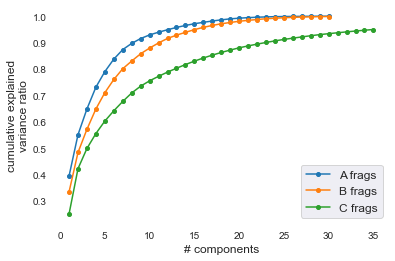

In [31]:
fig, ax = plt.subplots()

ax.plot(np.arange(cum_exp_var_a.shape[0])+1, cum_exp_var_a, marker='o', markersize=4, label='A frags')
ax.plot(np.arange(cum_exp_var_b.shape[0])+1, cum_exp_var_b, marker='o', markersize=4, label='B frags')
ax.plot(np.arange(cum_exp_var_c.shape[0])+1, cum_exp_var_c, marker='o', markersize=4, label='C frags')

ax.set_xlabel('# components', fontsize=12)
ax.set_ylabel('cumulative explained\nvariance ratio', fontsize=12)

ax.legend(loc='lower right', fontsize=12)

ax.set_facecolor('w')
plt.savefig('pca_exp_var_ratio.png', dpi=300)

In [220]:
# of components to choose
# A -->  30 --> ~1.0 EVR
# B --> 30 -->  ~1.0 EVR
# C --> 35 -->  0.9522642278929593 EVR

(array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29]),)

In [32]:
df_red_a.shape, df_red_b.shape, df_red_c.shape

((32, 31), (38, 31), (161, 36))

In [33]:
df_red_a.to_csv('gen2_pca_desc_a.csv', index=False)
df_red_b.to_csv('gen2_pca_desc_b.csv', index=False)
df_red_c.to_csv('gen2_pca_desc_c.csv', index=False)